<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Analyzing Profitability Growth with Alphalens

In the previous notebook, we saw that stocks of profitable companies (defined as companies with positive operating margins) perform better on a forward basis than stocks of unprofitable companies (defined as companies with negative operating margins). In looking at profitability, we were looking at a snapshot of a particular financial metric, but that doesn't tell us anything about the trend of that metric over time. Our top quantile may have included companies that were profitable but in decline, and our bottom quantile may have included companies that were unprofitable but getting better. In this notebook, we'll modify our analysis to look not at profitability but at profitability growth, that is, at the change in profitability over time.  

To measure profitability growth, we'll use the `PeriodicPercentChange` factor, discussed in the Periodic Computations notebook. To use our operating margin factor with a built-in periodic factor like `PeriodicPercentChange`, we need to put our factor logic inside a function that accepts `period_offset` and `mask` arguments: 

In [10]:
from zipline.pipeline import sharadar

def OPMARGIN(period_offset=0, mask=None):
    """
    Return an operating margin factor for the specified period_offset.
    """
    fundamentals = sharadar.Fundamentals.slice("ART", period_offset)
    revenue = fundamentals.REVENUE.latest
    operating_margin = fundamentals.OPINC.latest / revenue.where(revenue > 0) 

    # exclude companies with negative operating expenses or negative cost of revenue
    opex = fundamentals.OPEX.latest
    cor = fundamentals.COR.latest
    operating_margin = operating_margin.where((opex > 0) & (cor > 0))

    # clip range to (-1, 1) so as not to overweight outliers
    operating_margin = operating_margin.clip(min_bound=-1, max_bound=1)
    
    if mask is not None:
        operating_margin = operating_margin.where(mask)
        
    return operating_margin

We can then pass our function, as well as our base universe, to `PeriodicPercentChange()` to create a factor for profitability growth. We'll look at the change over 1 year, which corresponds to a `window_length` of 4 since we are using trailing-twelve-month data

explicitly limit our universe to companies with non-null operating margins. That is, we want to exclude from the pipeline output those records which we masked with NaNs according to our rules above (such as our `where()` statement to ignore zero revenue records). If we pass too many NaN values to Alphalens, Alphalens will fail and tell us that it had to drop too many records; we can avoid this by not passing the NaNs to Alphalens in the first place.  

In [11]:
from codeload.fundamental_factors.universe import BaseUniverse
from zipline.pipeline.periodic import PeriodicPercentChange

universe = BaseUniverse()
profitability_growth = PeriodicPercentChange(OPMARGIN, window_length=4, mask=universe)

As in the previous notebook, we should further limit our universe to exclude NaNs from the pipeline output that will be passed to Alphalens. The following statement does that.

> Python tip: writing `a &= b` is the same as writing `a = a & b`.

In [ ]:
# limit universe to non-nulls 
universe &= profitability_growth.notnull()

As in the previous notebook, we'll include a size column so we can see a breakdown of the factor by size quantiles:

In [8]:
from zipline.pipeline import Pipeline

fundamentals = sharadar.Fundamentals.slice("ART")
marketcap = fundamentals.MARKETCAP.latest

pipeline = Pipeline(
    columns={
        'profitability_growth': profitability_growth,
        'size': marketcap.quantiles(5, mask=universe) 
    },
    screen=universe
)

We then pass the pipeline object to Alphalens' `from_pipeline()` function. As in the previous notebook, we use `zero_aware=True` because 0 is the dividing line between companies whose profitability is growing vs declining. Since `PeriodicPercentChange()` is comparing current operating margin to the operating margin from 4 quarter ago, we must set the start date a year later than in the previous notebook to allow for the additional lookback window.  

## Tear sheet commentary

### Factor Distribution table

* `min`/`max`: The minimum value in quantile 1 and the maximum value in quantile 4 reflect the fact that we clipped operating margin to a range of (-1, 1).
* `min`/`max`: All values in quantiles 1 and 2 are negative, and all values in quantiles 3 and 4 are positive. This is because we specified `zero_aware=True`.
* `count %`: The negative quantiles (quantiles 1 and 2) are smaller in size than the positive quantiles (quantiles 3 and 4). This tells us that a majority of companies have positive operating margin. (If we did not specify `zero_aware=True`, the quantiles would be equally sized, and some of the positive values would show up in quantile 2.) 

### Returns Analysis

* `Mean Relative Return By Factor Quantile`: higher quantiles (positive operating margins) perform better than lower quantiles (negative operating margins). Most notably, the companies with the most negative operating margins (quantile 1) perform very poorly.
* `Factor-Weighted Long/Short Portfolio Cumulative Return`: this plot reflects a long/short portfolio where we long all stocks with positive operating margins and short all stocks with negative operating margins, with each position's weight being proportional to its factor value. Since we clipped the factor values using `clip()`, this plot is relatively smooth. If you don't clip or winsorize outliers, this plot may show extreme positive or negative performance, reflecting a highly concentrated portfolio.
* `Relative Cumulative Return by Quantile`: this plot shows the relative performance of 4 portfolios formed from the 4 quantiles, with positions being equal-weighted within each portfolio. While quantile 1 (containing companies with the most negative operating margin) performed very poorly over time, it spiked higher during the dotcom bubble of the late 1990s. 
* `Actual Cumulative Return by Quantile`: this plot consists of the same 4 portfolios (1 per quantile) as the previous plot, but now we see their actual returns rather than their relative returns. For example, whereas the previous plot showed a persistent decline in quantile 1 over time, in this plot we see that, since the dotcom crash of 2000-2003, the poor relative performance of quantile 1 is not because companies with negative operating margins have trended lower but rather because they have failed to trend upward along with other companies.
* `Bottom/Top Quantile Composition by size`: these pie charts are included because we specified a `groupby` column. The column was called "size" and reflected a division of the universe into 5 quantiles by market cap. Size quantile 0 contains the smallest companies and size quantile 4 contains the largest companies. The pie charts reveal that small companies (size quantile 0) are over-represented in the bottom factor quantile (that is, the quantile of companies with the most negative operating margin), and large companies (size quantile 4) are over-represented in the top factor quantile (that is, the quantile of companies with the highest operating margins. In other words, larger companies tend to have better operating margins than smaller companies. (The `quantiles()` method in Pipeline uses -1 to categorize NaN values, so the sliver in the pie chart corresponding to -1 indicates that a few stocks in the universe didn't have market cap data.)
* `Mean Relative Return plots by size quantile`: these bar charts show the mean relative return by factor quantile (that is, by operating margin quantile) for each of the size quantiles. These plots allow us to see if the factor behaves differently depending on company size. In the case of operating margin, factor quantile 1 (companies with the most negative operating margins) performs poorly in each of size quantiles 0-4, suggesting that the factor matters regardless of size. (The bar charts for size quantile -1 are best ignored; the preceding plots give us a hint that this size quantile (corresponding to NaN values for market data) has a small sample size.)    

,min,max,mean,std,count,avg daily count,count %
Factor Quantile,,,,,,,
1.0,"-28,903.770",-0.125,-4.405,157.171,"3,299,160",599.4,26.2%
2.0,-0.417,-0.000,-0.082,0.064,"3,296,355",598.9,26.2%
3.0,0.000,0.308,0.064,0.049,"2,998,745",544.8,23.8%
4.0,0.006,"19,958.862",4.068,150.733,"2,995,877",544.3,23.8%


,1D,21D,5D
Ann. alpha,0.139,0.120,0.126
beta,-0.277,-0.457,-0.334
Mean Relative Return Top Quantile (bps),0.749,0.126,0.391
Mean Relative Return Bottom Quantile (bps),-1.269,-0.529,-0.868
Mean Spread (bps),2.018,0.703,1.280


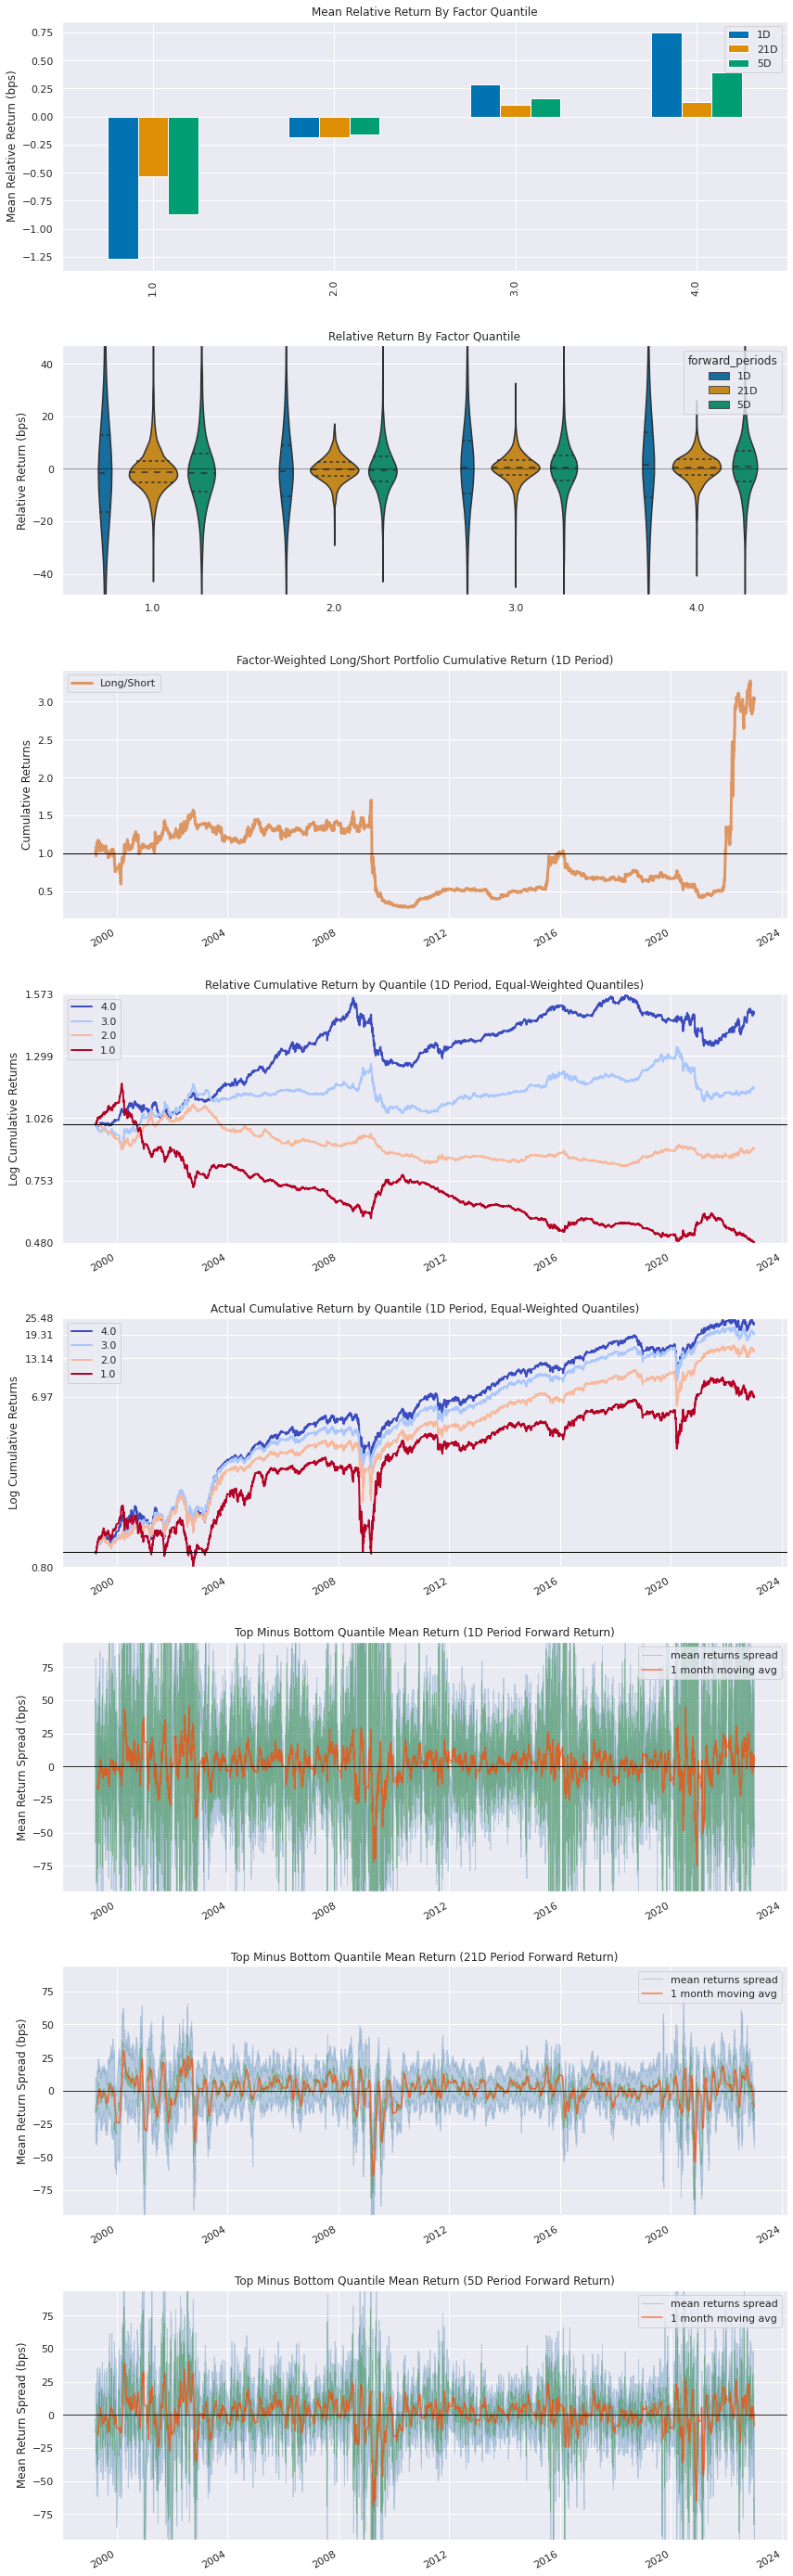

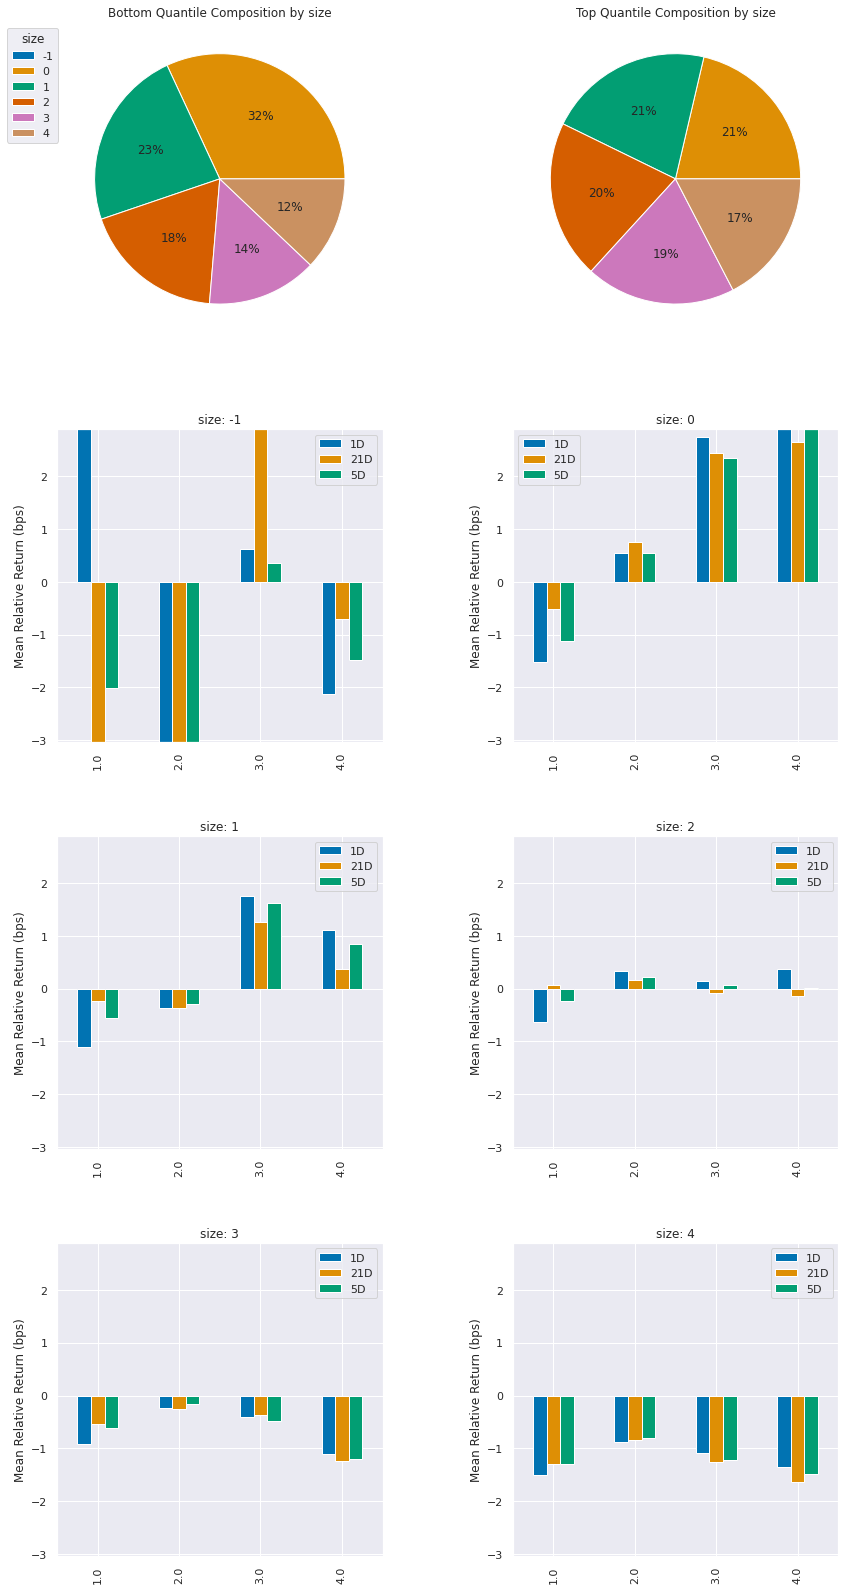

,1D,21D,5D
IC Mean,0.010,0.015,0.014
IC Std.,0.064,0.074,0.070
Risk-Adjusted IC,0.152,0.202,0.195
t-stat(IC),11.256,14.957,14.445
p-value(IC),0.000,0.000,0.000
IC Skew,-0.231,-0.750,-0.482
IC Kurtosis,1.807,1.982,1.462


/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


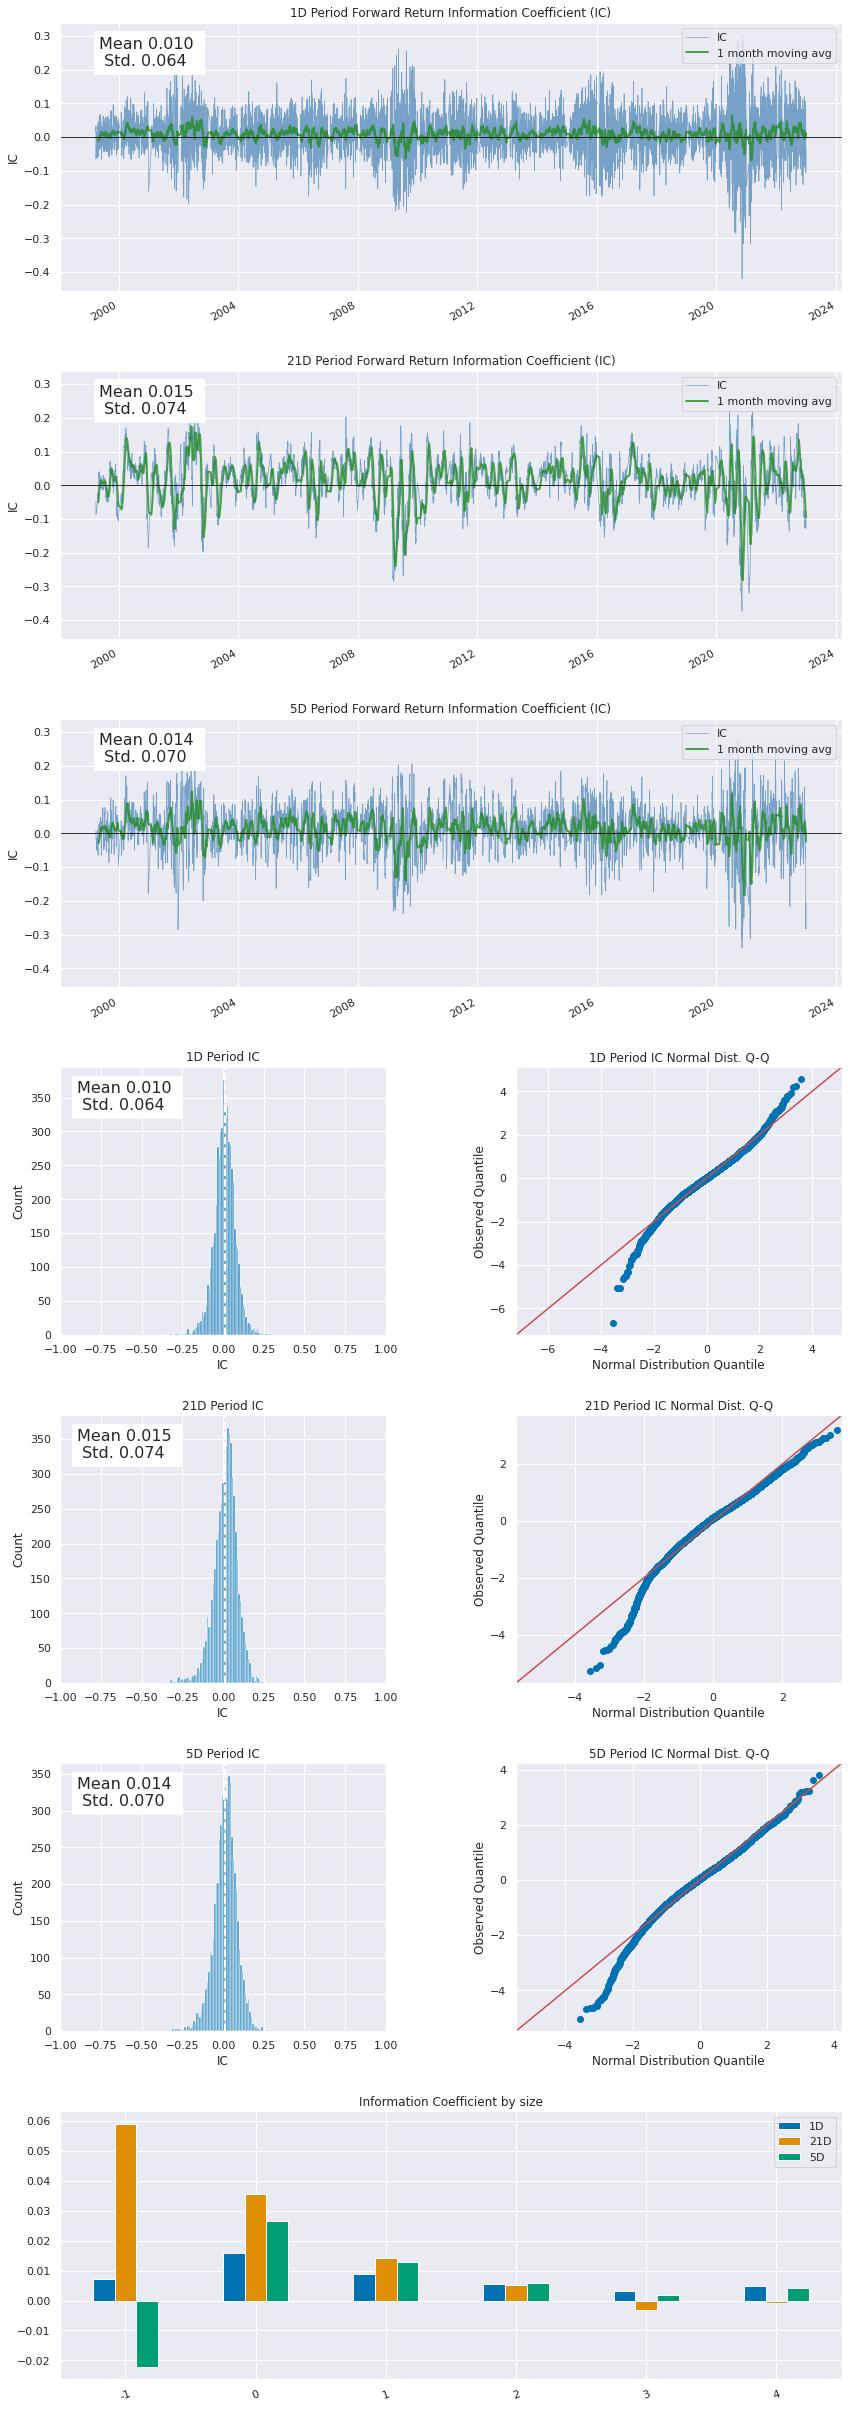

,1D,5D,21D
Quantile 1.0 Mean Turnover,0.009,0.040,0.146
Quantile 2.0 Mean Turnover,0.009,0.043,0.164
Quantile 3.0 Mean Turnover,0.010,0.045,0.174
Quantile 4.0 Mean Turnover,0.009,0.039,0.148


,1D,21D,5D
Mean Factor Rank Autocorrelation,0.996,0.907,0.978


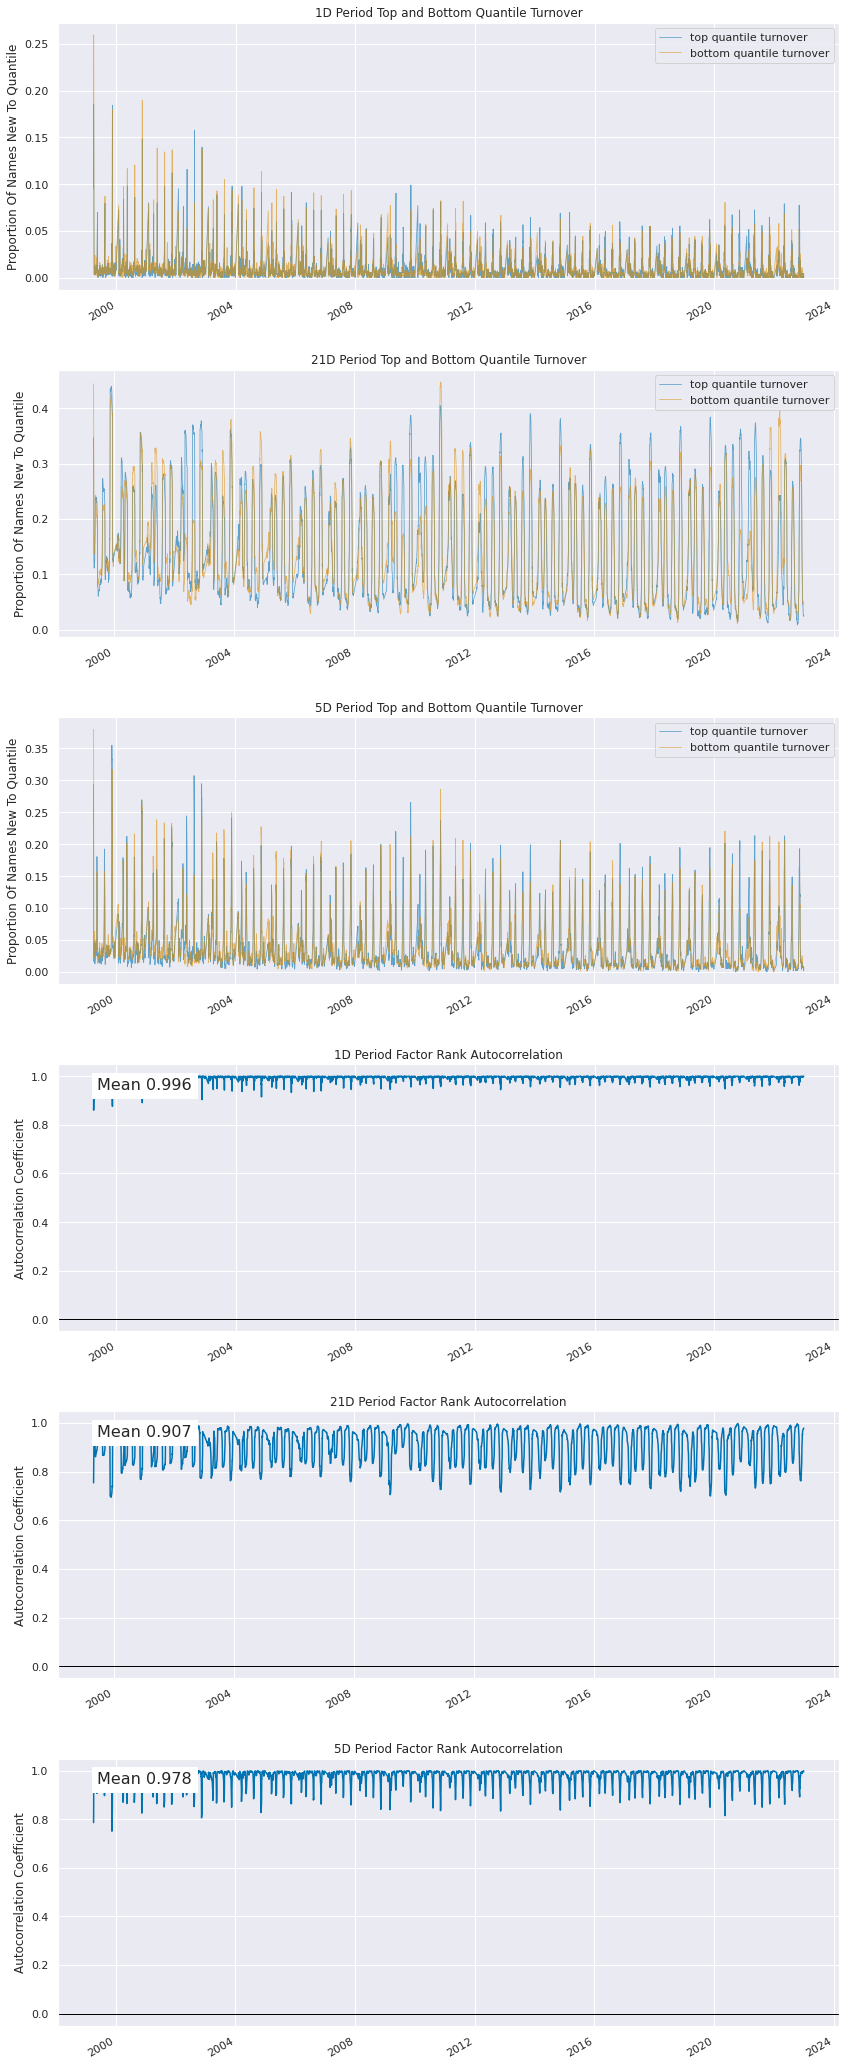

In [7]:
import alphalens as al

al.from_pipeline(
    pipeline,
    start_date="1999-02-01",
    end_date="2022-12-30",
    periods=[1, 5, 21],
    factor="profitability_growth",
    quantiles=4,
    zero_aware=True,
    groupby=[
        "size", 
    ],
    segment="Y"
)

## Tear sheet commentary

### Factor Distribution table

* `min`/`max`: The minimum value in quantile 1 and the maximum value in quantile 4 are very extreme, reflecting that we did not clip or winsorize the profitability growth factor (we only clipped the underlying operating margin factor.
* `count %`: The negative quantiles (quantiles 1 and 2) and the positive quantiles (quantiles 3 and 4) are more balanced in size than in the previous notebook, indicating that profitability is roughly equally likely to increase or decrease from year to year. 

### Returns Analysis

* `Table`: the mean spread of 2 BPS between the top and bottom quantile is smaller than the approx. 6 BPS mean spread in the previous notebook.  
* `Mean Relative Return By Factor Quantile`: companies with growing profitability (higher quantiles) perform better than companies with declining profitability (lower quantiles). Whereas most of the mean spread in the previous notebook was attributable to very poor performance in the bottom quantile (corresponding to companies with very negative operating margins), the plot in this notebook shows a more monotonic performance increase from left to right (that is, from declining profitability to growing profitability).
* `Factor-Weighted Long/Short Portfolio Cumulative Return`: the factor-weighted plot shows several very sharp up and down movements. This reflects that we did not clip or winsorize outliers, resulting in a highly concentrated portfolio due to the extreme minimum and maximum factor values (as indicated in the Factor Distribution table).
* `Relative Cumulative Return by Quantile`: this plot shows that the four quantiles generally performed as expected (stocks with growing profitability did better than stocks with declining profitability), but we can see periods when the bottom quantile outperformed, including the dotcom bubble of the late 1990s, the 2009 post-GFC recovery, and the 2021 post-Covid recovery. 
* `Mean Relative Return plots by size quantile`: size quantiles 0 and 1 (corresponding to the smallest 2/5th of companies) show strong relative returns in factor quantiles 3 and 4. This means that small companies with growing profitability have good returns. In contrast, profitability growth doesn't provide a meaningful performance benefit in size quantiles 3 and 4 (corresponding to the largest 2/5th of companies). Here, the performance is roughly the same regardless of factor quantile. This suggests that profitability growth in a large company may just be noise that doesn't necessarily result in better forward performance. A large company is already large, so growth may not be as meaningful a metric for large companies as for small companies. You might wonder how the bars for all four factor quantiles in size quantiles 3 and 4 can be negative. Remember, we are looking at relative returns in these plots, and they are relative to the mean return of the overall universe. In this particular tear sheet, the strong performance of small, growing stocks (factor quantiles 3 and 4 in size quantiles 0 and 1) drives up the overall mean and results in all large stocks (size quantiles 3 and 4) performing below the mean.

***

## *Next Up*

Lesson 8: [Factor Values vs Factor Ranks](Lesson08-Factor-Values-vs-Factor-Ranks.ipynb)